In [1]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,precision_score,accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [8]:
df = pd.read_csv('secom_cleaned.csv')

In [9]:
labels =df['label']
df = df.drop(['label'], axis=1)

### Scaling of Data

In [10]:
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df)
pca = PCA(n_components=0.95)
df = pca.fit_transform(df)
df = pd.DataFrame(df)
# Add the labels back to the data
df['label'] = labels
print("No.of columns in the Dataset:", len(df.columns))

No.of columns in the Dataset: 150


## Data Preprocessing for Training

In [5]:
# Data Preprocessing
df_normal = df[df['label'] == -1]
df_anomalous = df[df['label'] == 1]
df_normal = df_normal.drop(columns=['label'])
df_anomalous = df_anomalous.drop(columns=['label'])
# Data Distribution
print(f"Normal: {len(df_normal)}, Anomalous: {len(df_anomalous)}")

Normal: 1463, Anomalous: 104


## Training the Model

- **K-fold cross-validation** was used to ensure the model was trained on different subsets of the data. Since only a subset of the normal class was used for testing, relying on a single split might not provide the most reliable results. K-fold cross-validation helps mitigate this issue by training the model across multiple data folds, leading to a more robust evaluation.


### Sample Test Run

In [ ]:
# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Initialize an empty list to store the results
results = []
# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    # Split the data into training and test sets
    X_train, X_test = df_normal.iloc[train_index], df_normal.iloc[test_index]
    y_test = np.full(len(X_test), 0)
    # add anomalous data to the test set
    X_test = pd.concat([X_test, df_anomalous])
    y_test = np.concatenate([y_test, np.full(len(df_anomalous), 1)])
    
    # Train the Model
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
    model.fit(X_train)
    
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the results to the list
    results.append({
        'f1': f1,
        'precision': precision,
        'accuracy': accuracy
    })
    
print(f"F1 Score: {np.mean([result['f1'] for result in results])}")
print(f"Precision: {np.mean([result['precision'] for result in results])}")
print(f"Accuracy: {np.mean([result['accuracy'] for result in results])}")
print(f"Classification Report: {classification_report(y_test, y_pred)}")

F1 Score: 0.3340164700856071
Precision: 0.5864398516177027
Accuracy: 0.6104446215139443
Classification Report:               precision    recall  f1-score   support

           0       0.63      0.90      0.74       146
           1       0.64      0.24      0.35       104

    accuracy                           0.63       250
   macro avg       0.63      0.57      0.54       250
weighted avg       0.63      0.63      0.58       250



## Hyperparameter Tuning

In [15]:
def objective(trial):
    # hyperparameters
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    nu = trial.suggest_float('nu', 0.01, 0.5)
    
    # Handle gamma parameter with different options
    gamma_type = trial.suggest_categorical('gamma_type', ['scale', 'auto', 'numeric'])
    if gamma_type == 'numeric':
        gamma = trial.suggest_float('gamma', 1e-5, 1e2, log=True)
    else:
        gamma = gamma_type

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    precisions = []
    accuracies = []

    for train_index, test_index in kf.split(df_normal):
        # Data preparation
        X_train = df_normal.iloc[train_index]
        X_test_normal = df_normal.iloc[test_index]
        
        # Create test set with anomalies
        X_test = pd.concat([X_test_normal, df_anomalous])
        y_test = np.concatenate([np.zeros(len(X_test_normal)), 
                               np.ones(len(df_anomalous))])

        # Model training
        model = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
        model.fit(X_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred = [1 if x == -1 else 0 for x in y_pred]

        # Metric calculation
        f1_scores.append(f1_score(y_test, y_pred, pos_label=1))
        precisions.append(precision_score(y_test, y_pred, pos_label=1))
        accuracies.append(accuracy_score(y_test, y_pred))

    # Calculate mean metrics across folds
    avg_f1 = np.mean(f1_scores)
    avg_precision = np.mean(precisions)
    avg_accuracy = np.mean(accuracies)

    # Return sum of metrics for optimization
    return avg_f1 + avg_precision + avg_accuracy

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust number of trials as needed

# Best parameters
print("Best parameters:", study.best_params)
print(f"Best value (F1 + Precision + Accuracy): {study.best_value}")

[I 2025-04-02 15:05:06,662] A new study created in memory with name: no-name-c361beeb-c71c-4330-b00b-07ac34eef1e7
[I 2025-04-02 15:05:07,855] Trial 0 finished with value: 1.3998642896383033 and parameters: {'kernel': 'poly', 'nu': 0.38995114290909677, 'gamma_type': 'numeric', 'gamma': 0.004337231822660225}. Best is trial 0 with value: 1.3998642896383033.
[I 2025-04-02 15:05:08,531] Trial 1 finished with value: 1.3238918138744964 and parameters: {'kernel': 'linear', 'nu': 0.2907472899194228, 'gamma_type': 'scale'}. Best is trial 0 with value: 1.3998642896383033.
[I 2025-04-02 15:05:09,723] Trial 2 finished with value: 1.2946099278313603 and parameters: {'kernel': 'sigmoid', 'nu': 0.4636870326902502, 'gamma_type': 'auto'}. Best is trial 0 with value: 1.3998642896383033.
[I 2025-04-02 15:05:11,048] Trial 3 finished with value: 1.3998642896383033 and parameters: {'kernel': 'poly', 'nu': 0.37985846563431447, 'gamma_type': 'numeric', 'gamma': 0.3705746335135331}. Best is trial 0 with value: 

Best parameters: {'kernel': 'rbf', 'nu': 0.1810746726656964, 'gamma_type': 'scale'}
Best value (F1 + Precision + Accuracy): 1.5963835839643123


## Trainging and Validation of Model with Best Hyperparameters

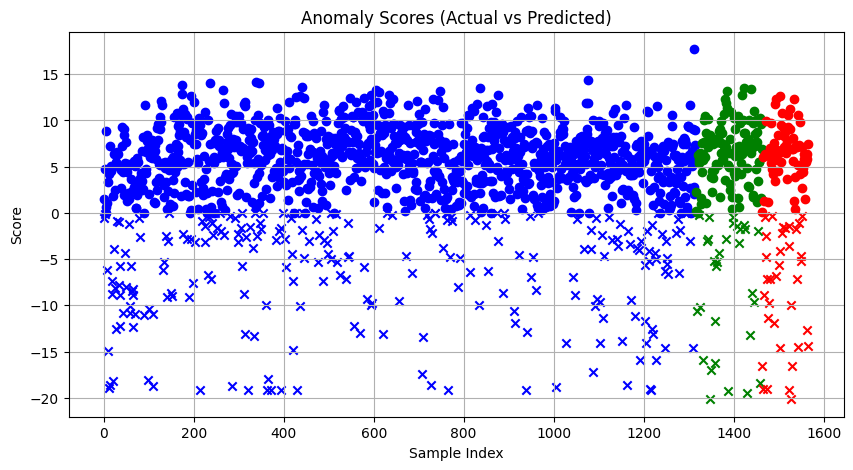

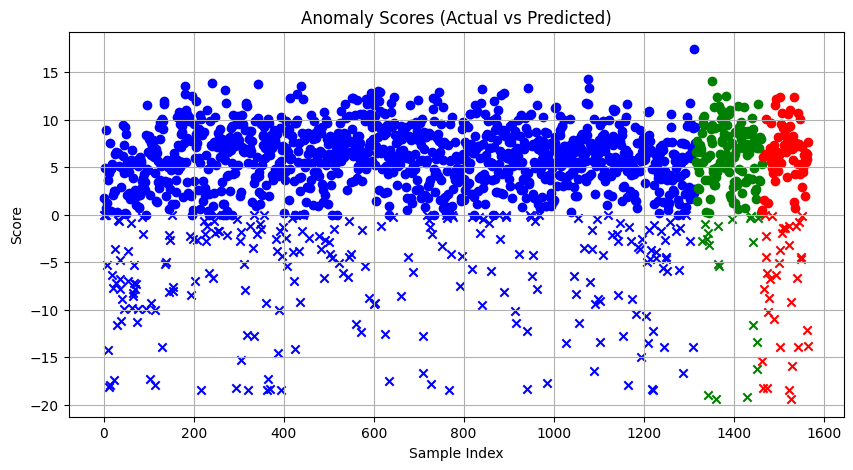

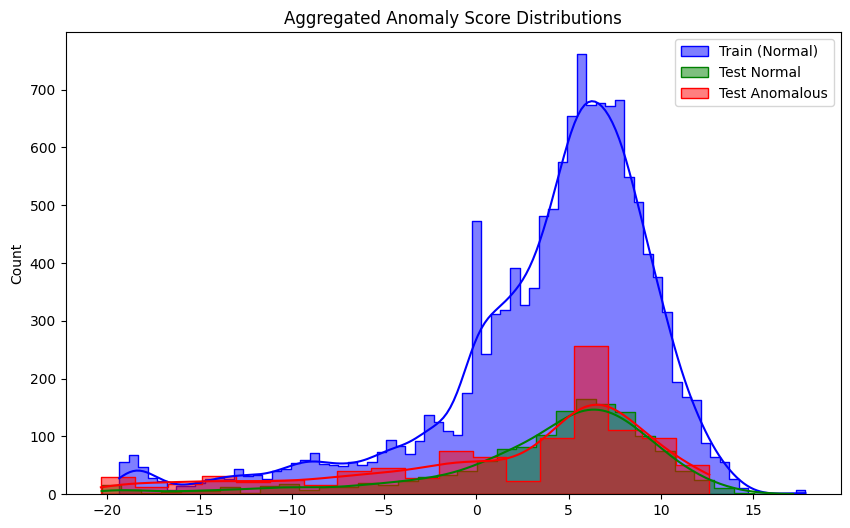

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.81      0.71      1463
         1.0       0.56      0.34      0.42      1040

    accuracy                           0.61      2503
   macro avg       0.59      0.57      0.57      2503
weighted avg       0.60      0.61      0.59      2503


Train Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90     13167
         1.0       0.00      0.00      0.00         0

    accuracy                           0.82     13167
   macro avg       0.50      0.41      0.45     13167
weighted avg       1.00      0.82      0.90     13167



In [6]:
# Final evaluation with best parameters
# best_params = study.best_params
best_params = {'kernel': 'rbf', 'nu': 0.1810746726656964, 'gamma_type': 'scale'}
gamma = best_params['gamma'] if 'gamma' in best_params else best_params['gamma_type']


# Initialize lists to store scores and labels for each fold
train_scores = []
test_scores = []
test_labels = []

all_y_test = []
all_y_pred = []

all_y_pred_train = []
all_y_test_train = []

# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
#defining n to print certain folds into the graph
n = 0
# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    n = n + 1
    
    # Data preparation
    X_train = df_normal.iloc[train_index]
    X_test_normal = df_normal.iloc[test_index]
    
    # Create test set with anomalies
    X_test = pd.concat([X_test_normal, df_anomalous])
    y_test = np.concatenate([np.zeros(len(X_test_normal)), 
                           np.ones(len(df_anomalous))])

    # Training with best parameters
    model = OneClassSVM(
        kernel=best_params['kernel'],
        gamma=gamma,
        nu=best_params['nu']
    )
    model.fit(X_train)

    # Get anomaly scores
    train_score = model.decision_function(X_train)
    test_score = model.decision_function(X_test)
    
    # Split test scores into normal and anomalous parts
    test_score_normal = test_score[:len(X_test_normal)]
    test_score_anomalous = test_score[len(X_test_normal):]
    
    # Store scores for aggregate analysis
    train_scores.extend(train_score)
    test_scores.extend(test_score_normal)
    test_scores.extend(test_score_anomalous)
    test_labels.extend([0]*len(test_score_normal))
    test_labels.extend([1]*len(test_score_anomalous))
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    y_pred_train = model.predict(X_train)
    y_pred_train = [1 if x == -1 else 0 for x in y_pred_train]
    
    # Collect classification data
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_train.extend(y_pred_train)
    all_y_test_train.extend(np.zeros(len(X_train)))
    
    if n<=2:# only print the first 2 folds for graphical representation
        # Plot anomaly scores with actual vs predicted
        plt.figure(figsize=(10, 5))
        # Training data (actual normal => color blue), marker based on predicted label
        train_markers = ['o' if p == 0 else 'x' for p in y_pred_train]
        for i in range(len(X_train)):
            plt.scatter(i, train_score[i], color='blue', marker=train_markers[i])

        # Test data (color depends on actual label; marker depends on predicted label)
        for i in range(len(X_test)):
            color = 'green' if y_test[i] == 0 else 'red'
            marker = 'o' if y_pred[i] == 0 else 'x'
            plt.scatter(i + len(X_train), test_score[i], color=color, marker=marker)

        plt.title("Anomaly Scores (Actual vs Predicted)")
        plt.xlabel("Sample Index")
        plt.ylabel("Score")
        plt.grid(True)
        plt.show()
    
# Aggregate histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(train_scores, color='blue', label='Train (Normal)', kde=True, element='step')
sns.histplot([s for s, l in zip(test_scores, test_labels) if l == 0], 
             color='green', label='Test Normal', kde=True, element='step')
sns.histplot([s for s, l in zip(test_scores, test_labels) if l == 1], 
             color='red', label='Test Anomalous', kde=True, element='step')
plt.legend()
plt.title('Aggregated Anomaly Score Distributions')
plt.show()

# Classification reports
print("Test Classification Report:")
print(classification_report(all_y_test, all_y_pred))

print("\nTrain Classification Report:")
print(classification_report(all_y_test_train, all_y_pred_train))